In [55]:
import numpy as np
import pandas as pd
import copy
import datetime
import collections
import traceback
import re
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from scipy.sparse import dok_matrix
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [33]:
train_source = fetch_20newsgroups(subset='train')
test_source = fetch_20newsgroups(subset='test')

print('Train size:', len(train_source['data']))
print('Test size', len(test_source['data']))

Train size: 11314
Test size 7532


In [34]:
print(train_source['data'][0].strip())
print('Label', train_source['target'][0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----
Label 7


In [35]:
TOKEN_RE = re.compile(r'[\w\d]+')

def tokenize_text_simple_regex(text, min_token_size=4):
    text = text.lower()
    all_tokens = TOKEN_RE.findall(text)
    return [token for token in all_tokens if len(token) >= min_token_size]

def tokenize_corpus(texts, tokenizer=tokenize_text_simple_regex, **tokenizer_kwargs):
    return [tokenizer(text, **tokenizer_kwargs) for text in texts]

In [36]:
train_tokenized = tokenize_corpus(train_source['data'])
test_tokenized = tokenize_corpus(test_source['data'])

print(' '.join(train_tokenized[0]))

from lerxst where thing subject what this nntp posting host rac3 organization university maryland college park lines wondering anyone there could enlighten this other door sports looked from late early called bricklin doors were really small addition front bumper separate from rest body this know anyone tellme model name engine specs years production where this made history whatever info have this funky looking please mail thanks brought your neighborhood lerxst


In [37]:
def build_vocabulary(tokenized_texts, max_size=1000000, max_doc_freq=0.8, min_count=5, pad_word=None):
    word_counts = collections.defaultdict(int)
    doc_count = 0

    for txt in tokenized_texts:
        doc_count += 1
        unique_text_tokens = set(txt)
        for token in unique_text_tokens:
            word_counts[token] += 1
    
    word_counts = {word: cnt for word, cnt in word_counts.items()
                   if cnt >= min_count and cnt / doc_count <= max_doc_freq}
    
    sorted_word_counts = sorted(word_counts.items(), reverse=True, key=lambda pair: pair[1])

    if pad_word is not None:
        sorted_word_counts = [(pad_word, 0)] + sorted_word_counts

    if(len(word_counts) > max_size):
        sorted_word_counts = sorted_word_counts[:max_size]

    word2id = {word: i for i, (word, _) in enumerate(sorted_word_counts)}

    word2freq = np.array([cnt / doc_count for _, cnt in sorted_word_counts], dtype='float32')

    return word2id, word2freq

In [38]:
MAX_DF = 0.8
MIN_COUNT = 5

vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)

UNIQUE_WORDS_N = len(vocabulary)

print('Count of unique tokens', UNIQUE_WORDS_N)
print(list(vocabulary.items())[:10])

Count of unique tokens 21628
[('that', 0), ('this', 1), ('have', 2), ('with', 3), ('writes', 4), ('article', 5), ('posting', 6), ('host', 7), ('nntp', 8), ('there', 9)]


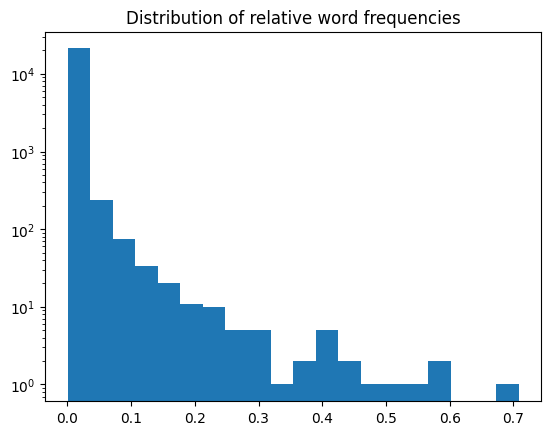

In [39]:
plt.hist(word_doc_freq, bins=20)
plt.title('Distribution of relative word frequencies')
plt.yscale('log')

In [40]:
def vectorize_texts(tokenized_texts, word2id, word2freq, mode='tfidf', scale=True):
    assert mode in {'tfidf', 'idf', 'tf', 'bin'}

    result = dok_matrix((len(tokenized_texts), len(word2id)), dtype=np.float32)
    for text_i, text in enumerate(tokenized_texts):
        for token in text:
            if token in word2id:
                result[text_i, word2id[token]] += 1
                
    if mode == 'bin':
        result = (result > 0).astype('float32')

    elif mode == 'tf':
        result = result.tocsr()
        result  = result.multiply(1 / result.sum(1))

    elif mode == 'idf':
        result = (result > 0).astype('float32').multiply(1 / word2freq)

    elif mode == 'tfidf':
        result = result.tocsr()
        result = result.multiply(1 / result.sum(1))
        result = result.multiply(1 / word2freq)

    if scale:
        result = result.tocsc()
        result -= result.min()
        result /= (result.max() + 1e-6)

    return result.tocsr()

In [41]:
VECTORIZATION_MODE = 'tfidf'

train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)
test_vectors = vectorize_texts(test_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)

print('Train matrix size', train_vectors.shape)
print('Test matrix size', test_vectors.shape)

print('Count of no zero elements in train matrix', train_vectors.nnz)
print('Procent of full train matrix {:.2f}%'.format(
    train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])
))

print('Count of no zero elements in test matrix', test_vectors.nnz)
print('Procent of full test matrix {:.2f}%'.format(
    test_vectors.nnz * 100 / (test_vectors.shape[0] * test_vectors.shape[1])
))

Train matrix size (11314, 21628)
Test matrix size (7532, 21628)
Count of no zero elements in train matrix 1126792
Procent of full train matrix 0.46%
Count of no zero elements in test matrix 721529
Procent of full test matrix 0.44%


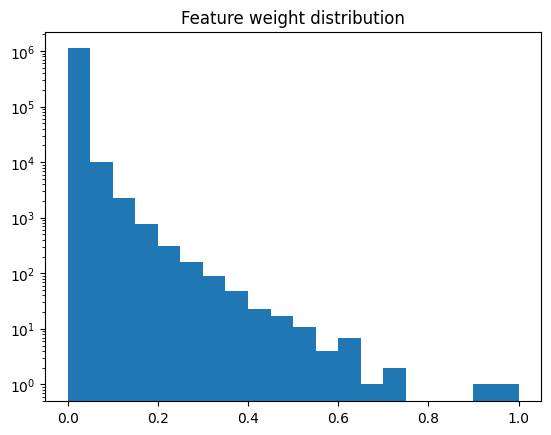

In [42]:
plt.hist(train_vectors.data, bins=20)
plt.title('Feature weight distribution')
plt.yscale('log')

In [43]:
class SparseFeaturesDataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
    def __len__(self):
        return self.features.shape[0]
    def __getitem__(self, idx):
        cur_features = torch.from_numpy(self.features[idx].toarray()[0]).float()
        cur_label = torch.from_numpy(np.asarray(self.targets[idx])).long()
        return cur_features, cur_label

In [44]:
UNIQUE_LABELS_N = len(set(train_source['target']))

In [ ]:
def train_eval_loop(model, train_dataset, val_dataset, criterion,
                    lr=1e-4, epoch_n=10, batch_size=32,
                    device='cuda', early_stopping_patience=10, l2_reg_alpha=0,
                    max_batches_per_epoch_train=10000,
                    max_batches_per_epoch_val=1000,
                    data_loader_ctor=DataLoader,
                    optimizer_ctor=None,
                    lr_scheduler_ctor=None,
                    shuffle_train=True):
    device = torch.device(device)
    model.to(device)

    if optimizer_ctor is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg_alpha)
    else:
        optimizer = optimizer_ctor(model.parameters(), lr=lr)
    
    if lr_scheduler_ctor is not None:
        lr_scheduler = lr_scheduler_ctor(optimizer)
    else:
        lr_scheduler = None
    
    train_dataloader = data_loader_ctor(train_dataset, batch_size=batch_size, shuffle=shuffle_train)
    val_dataloader = data_loader_ctor(val_dataset, batch_size=batch_size, shuffle=False)

    best_val_loss = float('inf')
    best_epoch_i = 0
    best_model = copy.deepcopy(model)

    for epoch_i in range(epoch_n):
        try:
            epoch_start = datetime.datetime.now()
            print('Эпоха {}'.format(epoch_i))

            model.train()
            mean_train_loss = 0
            train_batches_n = 0
            for batch_i, (batch_x, batch_y) in enumerate(train_dataloader):
                if batch_i > max_batches_per_epoch_train:
                    break

                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)

                pred = model(batch_x)
                loss = criterion(pred, batch_y)

                model.zero_grad()
                loss.backward()
                optimizer.step()

                mean_train_loss += float(loss)
                train_batches_n += 1

            mean_train_loss /= train_batches_n
            print('Эпоха: {} итераций, {:0.2f} сек'.format(batch_i, (datetime.datetime.now() - epoch_start).total_seconds()))
            print('Среднее значение функции потерь на обучении', mean_train_loss)

            model.eval()
            mean_val_loss = 0
            val_bathes_n = 0

            with torch.no_grad():
                for batch_i, (batch_x, batch_y) in enumerate(val_dataloader):
                    if batch_i > max_batches_per_epoch_val:
                        break

                    batch_x = batch_x.to(device)
                    batch_y = batch_y.to(device)

                    pred = model(batch_x)
                    loss = criterion(pred, batch_y)

                    mean_val_loss += float(loss)
                    val_bathes_n += 1
            
            mean_val_loss /= val_bathes_n
            print('Среднее значение функции потерь на валидации', mean_val_loss)
        
            if mean_val_loss < best_val_loss:
                best_epoch_i = epoch_i
                best_val_loss = mean_val_loss
                best_model = copy.deepcopy(model)
                print('Новая лучшая модель!')
            elif epoch_i - best_epoch_i > early_stopping_patience:
                print('Модель не улучшилась за последние {} эпох. Прекращаем обучение'.format(epoch_i - early_stopping_patience))
                break

            if lr_scheduler is not None:
                lr_scheduler.step(mean_val_loss)
            print()
        except KeyboardInterrupt:
            print('Досрочно остановлено пользователем')
            break
        except Exception as ex:
            print('Ошибка при обучени: {}\n{}'.format(ex, traceback.format_exc()))
            break
    return best_val_loss, best_model

In [46]:
train_dataset = SparseFeaturesDataset(train_vectors, train_source['target'])
test_dataset = SparseFeaturesDataset(test_vectors, test_source['target'])

In [49]:
model = nn.Linear(UNIQUE_WORDS_N, UNIQUE_LABELS_N)

def lr_scheduler(optim):
    return torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5, verbose=True)

best_val_loss, best_model = train_eval_loop(model=model,
                                            train_dataset=train_dataset,
                                            val_dataset=test_dataset,
                                            criterion=F.cross_entropy,
                                            lr=1e-1,
                                            epoch_n=200,
                                            batch_size=32,
                                            l2_reg_alpha=0,
                                            lr_scheduler_ctor=lr_scheduler)

Эпоха 0
Эпоха: 353 итераций, 1.31 сек
Среднее значение функции потерь на обучении 2.2315280413897023
Среднее значение функции потерь на валидации 2.1221728420863717
Новая лучшая модель!

Эпоха 1
Эпоха: 353 итераций, 1.20 сек
Среднее значение функции потерь на обучении 0.9202022768009854
Среднее значение функции потерь на валидации 1.6904544956603293
Новая лучшая модель!

Эпоха 2
Эпоха: 353 итераций, 1.27 сек
Среднее значение функции потерь на обучении 0.4669239350968162
Среднее значение функции потерь на валидации 1.4761680182764085
Новая лучшая модель!

Эпоха 3
Эпоха: 353 итераций, 1.20 сек
Среднее значение функции потерь на обучении 0.2843201517385278
Среднее значение функции потерь на валидации 1.34932513812841
Новая лучшая модель!

Эпоха 4
Эпоха: 353 итераций, 1.25 сек
Среднее значение функции потерь на обучении 0.19102289653935675
Среднее значение функции потерь на валидации 1.2611387091673028
Новая лучшая модель!

Эпоха 5
Эпоха: 353 итераций, 1.21 сек
Среднее значение функции пот

In [50]:
def predict_with_model(model, dataset, device='cuda', batch_size=32):
    results_by_batch = []

    device = torch.device(device)
    model.to(device)
    model.eval()

    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x = batch_x.to(device)

            batch_pred = model(batch_x)
            results_by_batch.append(batch_pred.detach().cpu().numpy())

    return np.concatenate(results_by_batch, 0)

In [52]:
train_pred = predict_with_model(best_model, train_dataset)
train_loss = F.cross_entropy(torch.from_numpy(train_pred), torch.from_numpy(train_source['target']))

print('Среднее значение функции потерь на обучении', float(train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], train_pred.argmax(-1)))

Среднее значение функции потерь на обучении 0.003140675835311413
Доля верных ответов 0.9992929114371575


In [53]:
test_pred = predict_with_model(best_model, test_dataset)
test_loss = F.cross_entropy(torch.from_numpy(test_pred), torch.from_numpy(test_source['target']))

print('Среднее значение функции потерь на обучении', float(test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], test_pred.argmax(-1)))

Среднее значение функции потерь на обучении 0.9392306208610535
Доля верных ответов 0.7639405204460966


In [56]:
sklearn_pipeline = Pipeline((('vect', TfidfVectorizer(tokenizer=tokenize_text_simple_regex, 
                                                      max_df=MAX_DF,
                                                      min_df=MIN_COUNT)),
                            ('cls', LogisticRegression())))
sklearn_pipeline.fit(train_source['data'], train_source['target'])

/home/nockerox/Desktop/ml-learn/env/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.8, min_df=5,
                                 tokenizer=<function tokenize_text_simple_regex at 0x7f92dd9de0c0>)),
                ('cls', LogisticRegression())])

In [57]:
sklearn_train_pred = sklearn_pipeline.predict_proba(train_source['data'])
sklearn_train_loss = F.cross_entropy(torch.from_numpy(sklearn_train_pred),
                                     torch.from_numpy(train_source['target']))
print('Среднее значение функции потерь на обучении', float(sklearn_train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], sklearn_train_pred.argmax(-1)))

Среднее значение функции потерь на обучении 2.495809522183968
Доля верных ответов 0.9715396853455895


In [58]:
sklearn_test_pred = sklearn_pipeline.predict_proba(test_source['data'])
sklearn_test_loss = F.cross_entropy(torch.from_numpy(sklearn_test_pred),
                                     torch.from_numpy(test_source['target']))
print('Среднее значение функции потерь на обучении', float(sklearn_test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], sklearn_test_pred.argmax(-1)))

Среднее значение функции потерь на обучении 2.6540611884047096
Доля верных ответов 0.8183749336165693
